# Collaboration and Competition

---

### 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

%matplotlib inline

Unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = UnityEnvironment(file_name = 'Tennis.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

The next cell shows the performance of a random agent and the commands needed to interact with the Unity environment.

In [4]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. Solving the Environment

Next we implement Proximal Policy Optimization (PPO) to solve the environment.

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

First, we import additional packages.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import sys
import time
import pandas as pd

In [6]:
%load_ext autoreload
%autoreload 2

For this environment, we'll be using DDPG and a couple of variations.

In [7]:
from models import DDPGModel, MADDPGModel, MAD3PGModel
from DDPG_agent import DDPGAgent
from MADDPG_agent import MADDPGAgent, MAD3PGAgent
from exploration_noise import OrnsteinUhlenbeckProcess as OUNoise, GaussianProcess

Next, we define our training function, which terminates once an agent has solved the environment. While solving the environment is defined as achieving an average score >= 0.5 over the the last 100 episodes, we wait until the agent acheives an average score of 1.0 until terminating the training process - a slightly more difficult task. For this project, each epsiode was allowed to continue until terminated by the environment; no limit on the number steps was imposed.

This first training function trains two separate agents that do not share any information.

In [8]:
def train_separately(env, agents, n_episodes = 10000, n_agents = 2,
                     evaluation_window = 100, verbose = 100, solved_score = 1.0):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    for agent in agents:
        agent.online_network.to(device)
        agent.target_network.to(device)
        agent.reset_current_step()
    
    scores = []
    
    for i in range(n_episodes):
        total_rewards = np.zeros(n_agents)
    
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations
        
        while True:
            actions = []
            for j in range(n_agents):
                action = agents[j].action(state[j])
                actions.append(action)

            env_info = env.step(np.array(actions))[brain_name]
            next_state = env_info.vector_observations
            reward = np.array(env_info.rewards)
            done = np.array(env_info.local_done)

            total_rewards += reward
            
            for j in range(n_agents):
                agents[j].update(state[j], actions[j], reward[j], next_state[j], done[j])

            if np.any(done):
                break

            state = next_state
        
        scores.append(np.max(total_rewards))
        
        average_score = np.mean(scores[-min(evaluation_window, i + 1):])
        current_score = scores[-1]
        print('\rEpisode {} | Score: {:.2f} | Average Score: {:.2f}'.format(i + 1, current_score, average_score), end = '')
        sys.stdout.flush()
        if (i + 1) % verbose == 0:
            print('')
            
        if average_score > solved_score:
            print('\nEnvironment solved in {} episodes'.format(i + 1))
            break
    
    return scores

This second train function trains agents that share observation and action information (more on this later).

In [9]:
def train_multi_agent(env, multi_agent, n_episodes = 10000, n_agents = 2,
                      evaluation_window = 100, verbose = 100, solved_score = 1.0):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    for i in range(n_agents):
        multi_agent.online_networks[i].to(device)
        multi_agent.target_networks[i].to(device)
    
    multi_agent.reset_current_step()
    
    scores = []
    
    for i in range(n_episodes):
        total_rewards = np.zeros(n_agents)
    
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations
        
        while True:
            action = multi_agent.action(state)
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = np.array(env_info.rewards)
            done = np.array(env_info.local_done)
            
            total_rewards += reward
            
            multi_agent.update(state, action, reward, next_state, done)

            if np.any(done):
                break

            state = next_state
        
        scores.append(np.max(total_rewards))
        
        average_score = np.mean(scores[-min(evaluation_window, i + 1):])
        current_score = scores[-1]
        print('\rEpisode {} | Score: {:.2f} | Average Score: {:.2f}'.format(i + 1, current_score, average_score), end = '')
        sys.stdout.flush()
        if (i + 1) % verbose == 0:
            print('')
            
        if average_score > solved_score:
            print('\nEnvironment solved in {} episodes'.format(i + 1))
            break
    
    return scores

Lastly, we define a couple of scheduler objects to allow us to more easily anneal the exploration parameters during training.

In [10]:
class ConstantScheduler():
    def __init__(self, value):
        self.value = value
        self.step = 0
        
    def __call__(self):
        self.step += 1
        value = self.value
        
        return value
        
    def reset(self):
        self.step = 0

class ExponentialScheduler():
    def __init__(self, start_value, end_value, rate):
        self.start_value = start_value
        self.end_value = end_value
        self.rate = rate
        self.value = start_value
        self.step = 0
        
        if end_value > start_value:
            assert rate > 1, 'Rate must be greater than one when the ending value is greater than the starting value'
            self.bound = min
        elif end_value < start_value:
            assert rate < 1, 'Rate must be less than one when the ending value is less than the starting value'
            self.bound = max
        else:
            raise ValueError('Start and end value cannot be the same')

    def __call__(self):
        self.step += 1
        value = self.value
        
        self.value = self.bound(self.value * self.rate, self.end_value)
        
        return value
        
    def reset(self):
        self.step = 0
        self.value = self.start_value

Next we define and train our agents! As a baseline, we start by training two separate DDPG agents. These agents do not share any information, such as the other agent's observation, action, etc. As such, each agent tries to find a policy that maximizes its own reward and the other agent's actions are simply part of the environment. Because each agent should learn to hit the ball over the net, the two agents should eventually learn to rally, keeping the ball in play for longer and longer. However, because there is no mechanism for agents to share information, it may be difficult for the agents to learn to cooperate and one agent may dominate the other, resulting in a suboptimal combined score.

Many of the hyperparameters below are fairly standard. In order to encourage sufficient exploration, we inject a significant amount of noise into the policy and reduce that noise as training proceeds. We experimented with using both an Ornstein-Uhlenbeck (OU) process to inject temporally correlated noise into the policy and a Gaussian process to inject normally distributed noise into the policy. Early experiments showed that Gaussian noise was almost consistently better than OU noise for this environment, and OU noise was not used in the runs below.

We start with a standard deviation parametetr of 1.5, which essentially encourages random actions for the first 1,000 or so episodes (actions are still clipped to be between -1.0 and 1.0 after noise is injected). While agents with lower levels of noise - lower standard deviation settings - were able to solve the environment (and sometimes faster), learning was less consistent and many times one of the agents would get stuck on a suboptimal policy, performing the same action regardless of the state. Encouraging more exploration alleivated this issue.

We trained three separate sets of agents with the same hyperparameters to understand the variation that occursduring training. For the below hyperparameters, each set of agents was able to solve the environment within about 2,000 to 3,000 episodes.

In [12]:
print('Separate DDPG Agents with Gaussian Noise')
separate_ddpg_gn_scores = []

for i in range(3):
    print('Run', i + 1)
    model_fn = lambda: DDPGModel(24, 2, critic_hidden_layers = (256, 128), actor_hidden_layers = (256, 128))

    DDPG_agents = [DDPGAgent(model_fn, 
                             exploration_noise = GaussianProcess((2, ), ExponentialScheduler(1.5, .1, .99995)),
                             gamma = 0.99,
                             clip_gradients = 1.0,
                             actor_learning_rate = 1e-4,
                             critic_learning_rate = 1e-3,
                             tau = 1e-3,
                             batch_size = 256, 
                             replay_start = 1000) for _ in range(2)]

    scores = train_separately(env, DDPG_agents, n_episodes = 5000, n_agents = 2,
                              evaluation_window = 100, verbose = 100, solved_score = 1.0)
    separate_ddpg_gn_scores.append(scores)
    print('')

Separate DDPG Agents with Gaussian Noise
Run 1
Episode 100 | Score: 0.00 | Average Score: 0.01
Episode 200 | Score: 0.00 | Average Score: 0.00
Episode 300 | Score: 0.00 | Average Score: 0.01
Episode 400 | Score: 0.00 | Average Score: 0.00
Episode 500 | Score: 0.00 | Average Score: 0.00
Episode 600 | Score: 0.00 | Average Score: 0.00
Episode 700 | Score: 0.00 | Average Score: 0.01
Episode 800 | Score: 0.00 | Average Score: 0.00
Episode 900 | Score: 0.00 | Average Score: 0.00
Episode 1000 | Score: 0.10 | Average Score: 0.01
Episode 1100 | Score: 0.00 | Average Score: 0.01
Episode 1200 | Score: 0.00 | Average Score: 0.01
Episode 1300 | Score: 0.09 | Average Score: 0.08
Episode 1400 | Score: 0.20 | Average Score: 0.07
Episode 1500 | Score: 0.10 | Average Score: 0.11
Episode 1600 | Score: 0.20 | Average Score: 0.14
Episode 1700 | Score: 0.10 | Average Score: 0.15
Episode 1800 | Score: 0.10 | Average Score: 0.23
Episode 1900 | Score: 0.50 | Average Score: 0.18
Episode 1967 | Score: 2.70 | Av

We'll quickly define a little helper function to convert the raw scores to moving averages.

In [17]:
def avg_scores(scores, window = 100):
    avg_scores = pd.Series(scores).rolling(window, min_periods = 1).mean()
    
    return avg_scores

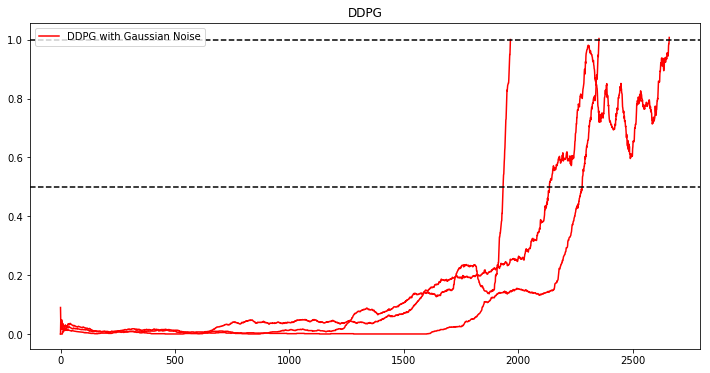

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))
for score in separate_ddpg_gn_scores:
    ax.plot(avg_scores(score), color = 'r', label = 'DDPG with Gaussian Noise')

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0]], [labels[0]], loc = 'upper left')

plt.axhline(1.0, color = 'k', linestyle = '--')
plt.axhline(0.5, color = 'k', linestyle = '--')
plt.title('DDPG')
plt.show()

Now that we have a baseline implementation to compare against, we move onto an implementation of multi-agent deep deterministic policy gradients (MADDPG). Similar to DDPG, MADDPG is an actor-critic algorithm that learns deterministic policies. While the actor networks are essentially identical - each taking the agent's observation as input and outputting a continuous action - each agent's critic has access to all the agents' observations and actions. This information sharing allows the critic to guide learning based on the steps the other agents take and has been shown to be effective for both competitive and collaborative tasks.

We use a similar set of hyperparameters for the MADDPG agents as we used for the separate DDPG agents, and, again, we trained three separate sets of agents to better understand the variation in training. The MADDPG agents did better with even more exploration, so we increased the standard deviation hyperparameter from 1.5 up to 3.0. 

The MADDPH agents solved the environment in a similar number of steps (between about 2,000 and 3,000), but exhibited less variation between runs as can be seen from the smaller range of scores in the graphs below. That said, each agent was only run 3 times, so additional runs may show a different pattern.

In [16]:
print('MADDPG Agents with Gaussian Noise')
maddpg_gn_scores = []

for i in range(3):
    print('Run', i + 1)
    model_fn = lambda: MADDPGModel(2, 24, 2, critic_hidden_layers = (256, 128), actor_hidden_layers = (256, 128))

    MADDPG_agents = MADDPGAgent(2, model_fn,
                                exploration_noise_fn = lambda: GaussianProcess((2, ), 
                                                                               ExponentialScheduler(3.0, .1, .99995)),
                                batch_size = 256, 
                                replay_start = 1000,
                                tau = 1e-3,
                                actor_learning_rate = 1e-4,
                                critic_learning_rate = 1e-3,
                                clip_gradients = 1.0,
                                share_weights = False)

    scores = train_multi_agent(env, MADDPG_agents, n_episodes = 5000, n_agents = 2,
                               evaluation_window = 100, verbose = 100, solved_score = 1.0)
    maddpg_gn_scores.append(scores)
    print('')

MADDPG Agents with Gaussian Noise
Run 1
Episode 100 | Score: 0.00 | Average Score: 0.02
Episode 200 | Score: 0.00 | Average Score: 0.02
Episode 300 | Score: 0.00 | Average Score: 0.01
Episode 400 | Score: 0.00 | Average Score: 0.02
Episode 500 | Score: 0.00 | Average Score: 0.01
Episode 600 | Score: 0.00 | Average Score: 0.01
Episode 700 | Score: 0.00 | Average Score: 0.02
Episode 800 | Score: 0.10 | Average Score: 0.02
Episode 900 | Score: 0.10 | Average Score: 0.03
Episode 1000 | Score: 0.00 | Average Score: 0.03
Episode 1100 | Score: 0.10 | Average Score: 0.04
Episode 1200 | Score: 0.10 | Average Score: 0.04
Episode 1300 | Score: 0.00 | Average Score: 0.04
Episode 1400 | Score: 0.00 | Average Score: 0.05
Episode 1500 | Score: 0.10 | Average Score: 0.04
Episode 1600 | Score: 0.00 | Average Score: 0.04
Episode 1700 | Score: 0.10 | Average Score: 0.05
Episode 1800 | Score: 0.09 | Average Score: 0.07
Episode 1900 | Score: 0.10 | Average Score: 0.09
Episode 2000 | Score: 0.09 | Average S

Comparing the separate DDPG agents and the MADDPG agents, 

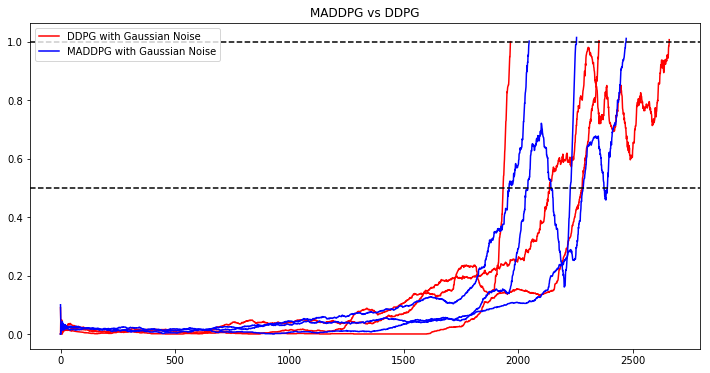

In [19]:
fig, ax = plt.subplots(figsize = (12, 6))
for score in separate_ddpg_gn_scores:
    ax.plot(avg_scores(score), color = 'r', label = 'DDPG with Gaussian Noise')

for score in maddpg_gn_scores:
    ax.plot(avg_scores(score), color = 'b', label = 'MADDPG with Gaussian Noise')
    
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[3]], [labels[0], labels[3]], loc = 'upper left')

plt.axhline(1.0, color = 'k', linestyle = '--')
plt.axhline(0.5, color = 'k', linestyle = '--')
plt.title('MADDPG vs DDPG')
plt.show()

Because the critic's architecture is the main difference between the separate DDPG agents and the MADDPG agents, we hypothesize that a more robust critic would further improve the time it takes for the agents' to solve the environment. Therefore, next, we introduce multi-agent distributional deep deterministic policy gradients (MAD3PG), inspired by distributed distributional deep deterministic policy gradients (D4PG) and using a quantile regression critic based on QR-DQN. Instead of the learning the mean state-action value, this agent's critic learns the entire state-action value distribution, based on the quantiles of the distribution. Unlike D4PG, we do not use distributed training or n-step methods and we replace the categorical critic with the quantile regression critic, primarily for simplicity and to avoid the projection step required in Categorical DQN. For the agents below, we used 25 quantiles to estimate the state-action value distribution. 

The MAD3PG agents also use similar hyperparameters to the agents above, but we found that removing gradient clipping from these agents produced better results. Besides from gradient clipping and testing a few different values of the standard deviation parameter that controls exploration, no other hyperparameter tuning was done.

In [21]:
print('MAD3PG Agents with Gaussian Noise')
mad3pg_gn_scores = []

for i in range(3):
    print('Run', i + 1)
    model_fn = lambda: MAD3PGModel(2, 24, 2, 25, critic_hidden_layers = (256, 128), actor_hidden_layers = (256, 128))

    MAD3PG_agents = MAD3PGAgent(2, model_fn, 25,
                                exploration_noise_fn = lambda: GaussianProcess((2, ), 
                                                                               ExponentialScheduler(3.0, .1, .99995)),
                                batch_size = 256, 
                                replay_start = 1000,
                                tau = 1e-3,
                                actor_learning_rate = 1e-4,
                                critic_learning_rate = 1e-3,
                                clip_gradients = None,
                                share_weights = False)

    scores = train_multi_agent(env, MAD3PG_agents, n_episodes = 5000, n_agents = 2,
                               evaluation_window = 100, verbose = 100, solved_score = 1.0)
    mad3pg_gn_scores.append(scores)
    print('')

MAD3PG Agents with Gaussian Noise
Run 1
Episode 100 | Score: 0.00 | Average Score: 0.02
Episode 200 | Score: 0.00 | Average Score: 0.01
Episode 300 | Score: 0.00 | Average Score: 0.01
Episode 400 | Score: 0.00 | Average Score: 0.01
Episode 500 | Score: 0.00 | Average Score: 0.00
Episode 600 | Score: 0.00 | Average Score: 0.01
Episode 700 | Score: 0.00 | Average Score: 0.01
Episode 800 | Score: 0.10 | Average Score: 0.03
Episode 900 | Score: 0.00 | Average Score: 0.02
Episode 1000 | Score: 0.20 | Average Score: 0.03
Episode 1100 | Score: 0.00 | Average Score: 0.02
Episode 1200 | Score: 0.00 | Average Score: 0.05
Episode 1300 | Score: 0.10 | Average Score: 0.05
Episode 1400 | Score: 0.09 | Average Score: 0.04
Episode 1500 | Score: 0.10 | Average Score: 0.06
Episode 1600 | Score: 0.00 | Average Score: 0.08
Episode 1700 | Score: 0.10 | Average Score: 0.12
Episode 1800 | Score: 0.10 | Average Score: 0.11
Episode 1900 | Score: 0.10 | Average Score: 0.16
Episode 2000 | Score: 0.20 | Average S

Finally, we compare our baseline separate DDPG agents to the MAD3PG agents

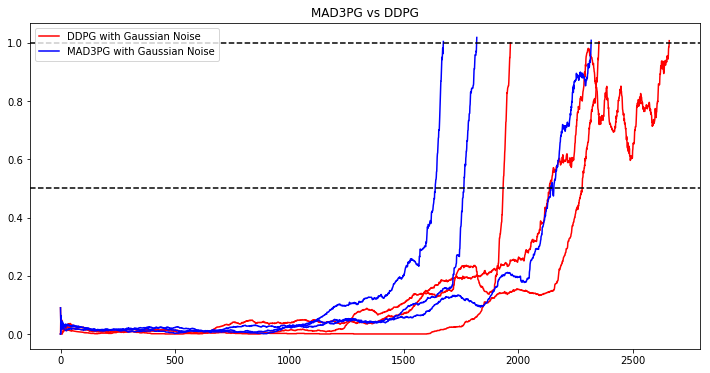

In [25]:
fig, ax = plt.subplots(figsize = (12, 6))
for score in separate_ddpg_gn_scores:
    ax.plot(avg_scores(score), color = 'r', label = 'DDPG with Gaussian Noise')
    
for score in mad3pg_gn_scores:
    ax.plot(avg_scores(score), color = 'b', label = 'MAD3PG with Gaussian Noise')
    
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[3]], [labels[0], labels[3]], loc = 'upper left')
    
plt.axhline(1.0, color = 'k', linestyle = '--')
plt.axhline(0.5, color = 'k', linestyle = '--')
plt.title('MAD3PG vs DDPG')
plt.show()

As can be seen from the graph above, the MAD3PG agents generally solved the environment faster, with 2 out of 3 runs solving the environment faster than the best DDPG run. Additionally, 2 out of 3 agents solved the environment in less than 2,000 episodes, a difficult feat for the other agents.

Lastly, we save the weights and biases of the last MAD3PG agent and close the environment.

In [26]:
torch.save(MAD3PG_agents.online_networks[0].state_dict(), 'MAD3PG_agent_1_online_networks.pt')
torch.save(MAD3PG_agents.online_networks[1].state_dict(), 'MAD3PG_agent_2_online_networks.pt')
torch.save(MAD3PG_agents.target_networks[0].state_dict(), 'MAD3PG_agent_1_target_networks.pt')
torch.save(MAD3PG_agents.target_networks[1].state_dict(), 'MAD3PG_agent_2_target_networks.pt')

In [27]:
env.close()

### 5. Ideas for Future Work

While all the agents were able to solve the environment within about 3,000 episodes, very little hyperparameter tuning was done given the amount of time training took. Most likely, significant improvement could be made on this task using the same agent designs with better hyperparameters.

While we used some of the ideas from D4PG, other aspects of that agent could be used, including distributed training, n-step methods, and prioritized experience replay.

DDPG is also not the only algorithm that can accomodate continuous policies; multi-agent versions of A2C, PPO and other stochastic policy agents could provide additional improvements over the deterministic policy agents used herein. 

Finally, we used the simplest version of MADDPG. In the original paper, agents with an ensemble of policies generally performed better than the single policy agents. This could improve training time as each agent's ensemble policy may be more robust to changes in the other agent's policy.